In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

- Auxiliar functions

In [47]:
def check_data_in_range(value, min_value, max_value):
    if value > max_value or value < min_value:
        return True
    else:
        return False

In [48]:
def generate_df_count(df_values, name_columns):
    matrix_data = []

    for column in df_values.columns:

        value_counts = df_values[column].value_counts()

        row = [column, 0, 0]

        if True in value_counts.index:
            row[1] = value_counts[True]
        if False in value_counts.index:
            row[2] = value_counts[False]
        
        matrix_data.append(row)

    df_summary = pd.DataFrame(data=matrix_data, columns=name_columns)
    return df_summary

- Lectura y descripcion del dataset

In [49]:
df_data = pd.read_csv("gdm_first_trimester_ml_dataset.csv")
df_data.head(4)

,age_years,bmi_prepreg_kg_m2,systolic_bp_mmHg,diastolic_bp_mmHg,map_mmHg,gestational_weeks,fpg_mmol_l,hba1c_percent,insulin_uIU_ml,homa_ir,triglycerides_mmol_l,hdl_mmol_l,parity,family_history_t2d,previous_gdm,pcos,smoking_first_trimester,physical_activity_level,diet_score_0_100,label_gdm
0,26.8,26.9,119.0,57.0,77.7,8.7,4.10,5.33,7.8,1.42,1.37,1.36,0,0,1,0,1,2.0,62.0,0
1,22.6,27.3,NaN,69.0,80.8,9.0,3.53,5.73,7.2,1.12,1.13,1.60,0,1,0,1,0,1.0,42.0,0
2,29.9,33.1,103.0,84.0,89.9,10.3,4.45,NaN,4.3,0.86,1.27,1.16,0,1,0,0,0,1.0,72.0,0
3,26.3,23.6,112.0,69.0,83.3,12.2,4.79,4.69,13.7,2.91,1.22,1.73,0,0,0,0,0,0.0,81.0,0


- Inspeccione dimensiones del dataset, tipos de datos y valores faltantes.

In [50]:
df_data.shape

(1500, 20)

In [51]:
df_data.dtypes

age_years                  float64
bmi_prepreg_kg_m2          float64
systolic_bp_mmHg           float64
diastolic_bp_mmHg          float64
map_mmHg                   float64
gestational_weeks          float64
fpg_mmol_l                 float64
hba1c_percent              float64
insulin_uIU_ml             float64
homa_ir                    float64
triglycerides_mmol_l       float64
hdl_mmol_l                 float64
parity                       int64
family_history_t2d           int64
previous_gdm                 int64
pcos                         int64
smoking_first_trimester      int64
physical_activity_level    float64
diet_score_0_100           float64
label_gdm                    int64
dtype: object

In [52]:
df_null = df_data.isna()
df_summary_null= generate_df_count(df_null, ["descriptor", "count_null", "count_not_null"])
df_summary_null.sort_values(by="count_null", ascending=False)

,descriptor,count_null,count_not_null
7,hba1c_percent,162,1338
10,triglycerides_mmol_l,148,1352
6,fpg_mmol_l,109,1391
8,insulin_uIU_ml,108,1392
11,hdl_mmol_l,86,1414
17,physical_activity_level,70,1430
18,diet_score_0_100,69,1431
2,systolic_bp_mmHg,45,1455
3,diastolic_bp_mmHg,36,1464
1,bmi_prepreg_kg_m2,0,1500


- Analice estad ́ısticos descriptivos de cada variable.

In [53]:
categorical_columns=["parity", "family_history_t2d", "previous_gdm",
                     "pcos", "smoking_first_trimester", "label_gdm"]

In [54]:
matrix_descriptors = []

for column in df_data.columns:
    if column not in categorical_columns:
        value_descriptors = df_data[column].describe()

        IQR = value_descriptors["75%"] - value_descriptors["25%"]

        row = {
            "descriptor" : column,
            "mean": value_descriptors["mean"],
            "std": value_descriptors["std"],
            "25%": value_descriptors["25%"],
            "50%": value_descriptors["50%"],
            "75%": value_descriptors["75%"],
            "IQR": IQR,
            "max_range" : value_descriptors["75%"] + IQR*1.5,
            "min_range" : value_descriptors["25%"] - IQR*1.5
        }

        matrix_descriptors.append(row)
        
df_descriptors_statistical = pd.DataFrame(matrix_descriptors)
df_descriptors_statistical

,descriptor,mean,std,25%,50%,75%,IQR,max_range,min_range
0,age_years,29.129600,4.988332,25.6000,29.100,32.525,6.9250,42.91250,15.21250
1,bmi_prepreg_kg_m2,26.284738,5.005360,22.9000,26.350,29.400,6.5000,39.15000,13.15000
2,systolic_bp_mmHg,112.029553,12.254459,104.0000,112.000,120.000,16.0000,144.00000,80.00000
3,diastolic_bp_mmHg,70.535519,8.516566,65.0000,70.000,76.000,11.0000,92.50000,48.50000
4,map_mmHg,84.398244,7.215258,79.7000,84.300,88.900,9.2000,102.70000,65.90000
5,gestational_weeks,10.811667,1.611753,9.4000,10.800,12.200,2.8000,16.40000,5.20000
6,fpg_mmol_l,4.801589,0.977795,4.3000,4.710,5.150,0.8500,6.42500,3.02500
7,hba1c_percent,5.218923,0.376506,5.0000,5.200,5.400,0.4000,6.00000,4.40000
8,insulin_uIU_ml,10.990520,4.487567,8.0750,10.200,12.900,4.8250,20.13750,0.83750
9,homa_ir,2.394468,1.683579,1.6400,2.120,2.720,1.0800,4.34000,0.02000


- Descriptores categoricos

In [55]:
for column in categorical_columns:
    print(df_data[column].value_counts())

parity
1    561
0    545
2    269
3    101
4     20
5      4
Name: count, dtype: int64
family_history_t2d
0    1043
1     457
Name: count, dtype: int64
previous_gdm
0    1351
1     149
Name: count, dtype: int64
pcos
0    1351
1     149
Name: count, dtype: int64
smoking_first_trimester
0    1331
1     169
Name: count, dtype: int64
label_gdm
0    1239
1     261
Name: count, dtype: int64


- Identifique posibles outliers.

In [56]:
df_outliers = pd.DataFrame()

for column in df_data.columns:
    if column not in categorical_columns:
        filter_value = df_descriptors_statistical[df_descriptors_statistical["descriptor"] == column]
        filter_value.reset_index(inplace=True)

        min_value, max_value = filter_value["min_range"][0], filter_value["max_range"][0]

        df_outliers[column] = df_data[column].apply(lambda x: check_data_in_range(x, min_value, max_value))
df_outliers

,age_years,bmi_prepreg_kg_m2,systolic_bp_mmHg,diastolic_bp_mmHg,map_mmHg,gestational_weeks,fpg_mmol_l,hba1c_percent,insulin_uIU_ml,homa_ir,triglycerides_mmol_l,hdl_mmol_l,physical_activity_level,diet_score_0_100
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,False,True,True,False,False,False,True,True,True,True,True,False,False,False
1496,False,False,False,True,True,False,False,False,False,False,False,False,False,False
1497,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1498,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [57]:
df_summary_outlier= generate_df_count(df_outliers, ["descriptor", "count_outlier", "count_not_outlier"])
df_summary_outlier.sort_values(by="count_outlier", ascending=False)

,descriptor,count_outlier,count_not_outlier
9,homa_ir,59,1441
8,insulin_uIU_ml,46,1454
10,triglycerides_mmol_l,45,1455
7,hba1c_percent,24,1476
6,fpg_mmol_l,24,1476
4,map_mmHg,23,1477
11,hdl_mmol_l,20,1480
3,diastolic_bp_mmHg,18,1482
13,diet_score_0_100,14,1486
1,bmi_prepreg_kg_m2,13,1487


In [58]:
df_data_categorical = df_data[categorical_columns]
df_data_categorical = df_data_categorical.drop(columns=["label_gdm"])
df_data_categorical

,parity,family_history_t2d,previous_gdm,pcos,smoking_first_trimester
0,0,0,1,0,1
1,0,1,0,1,0
2,0,1,0,0,0
3,0,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
1495,1,0,0,0,0
1496,0,0,1,0,0
1497,2,0,0,0,1
1498,0,0,1,0,0


In [59]:
instance_IF = IsolationForest(random_state=42)
instance_IF.fit(df_data_categorical)
predictions_outlier = instance_IF.predict(df_data_categorical)

In [60]:
df_data_categorical["is_isolated"] = predictions_outlier
df_data_categorical["is_isolated"].value_counts()

is_isolated
 1    1032
-1     468
Name: count, dtype: int64

In [61]:
columns_no_categorical = [column for column in df_data.columns if column not in categorical_columns]
df_no_categorical = df_data[columns_no_categorical]

instance_IF = IsolationForest(random_state=42)
instance_IF.fit(df_no_categorical)
predictions_outlier = instance_IF.predict(df_no_categorical)
df_no_categorical["is_isolated"] = predictions_outlier 
df_no_categorical["is_isolated"].value_counts()

is_isolated
 1    1416
-1      84
Name: count, dtype: int64

In [62]:
df_values = df_data.drop(columns=["label_gdm"])
instance_IF = IsolationForest(random_state=42)
instance_IF.fit(df_values)

predictions_outlier = instance_IF.predict(df_values)
df_values["is_isolated"] = predictions_outlier 
df_values["is_isolated"].value_counts()

is_isolated
 1    1315
-1     185
Name: count, dtype: int64

In [63]:
df_values["label_gdm"] = df_data["label_gdm"].values

In [64]:
df_values.groupby(by=["label_gdm", "is_isolated"]).count()

age_years  bmi_prepreg_kg_m2  systolic_bp_mmHg  \
label_gdm is_isolated                                                   
0         -1                 137                137               132   
           1                1102               1102              1072   
1         -1                  48                 48                46   
           1                 213                213               205   

                       diastolic_bp_mmHg  map_mmHg  gestational_weeks  \
label_gdm is_isolated                                                   
0         -1                         134       137                137   
           1                        1074      1102               1102   
1         -1                          47        48                 48   
           1                         209       213                213   

                       fpg_mmol_l  hba1c_percent  insulin_uIU_ml  homa_ir  \
label_gdm is_isolated                                                       
0         -1                  130            132             129      137   
           1                 1020            978            1020     1102   
1         -1                   48             44              45       48   
           1                  193            184             198      213   

                       triglycerides_mmol_l  hdl_mmol_l  parity  \
label_gdm is_isolated                                             
0         -1                            125         132     137   
           1                            996        1037    1102   
1         -1                             42          45      48   
           1                            189         200     213   

                       family_history_t2d  previous_gdm  pcos  \
label_gdm is_isolated                                           
0         -1                          137           137   137   
           1                         1102          1102  1102   
1         -1                           48            48    48   
           1                          213           213   213   

                       smoking_first_trimester  physical_activity_level  \
label_gdm is_isolated                                                     
0         -1                               137                      130   
           1                              1102                     1053   
1         -1                                48                       46   
           1                               213                      201   

                       diet_score_0_100  
label_gdm is_isolated                    
0         -1                        132  
           1                       1050  
1         -1                         45  
           1                        204

In [65]:
df_outliers

,age_years,bmi_prepreg_kg_m2,systolic_bp_mmHg,diastolic_bp_mmHg,map_mmHg,gestational_weeks,fpg_mmol_l,hba1c_percent,insulin_uIU_ml,homa_ir,triglycerides_mmol_l,hdl_mmol_l,physical_activity_level,diet_score_0_100
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,False,True,True,False,False,False,True,True,True,True,True,False,False,False
1496,False,False,False,True,True,False,False,False,False,False,False,False,False,False
1497,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1498,False,False,False,False,False,False,False,False,False,False,True,False,False,False


- Análisis e imputacion de valores nulos

In [66]:
columns_with_null = ["hba1c_percent",
"triglycerides_mmol_l",
"fpg_mmol_l",
"insulin_uIU_ml",
"hdl_mmol_l",
"physical_activity_level",
"diet_score_0_100",
"systolic_bp_mmHg",
"diastolic_bp_mmHg"]

- Visualizar las distribuciones

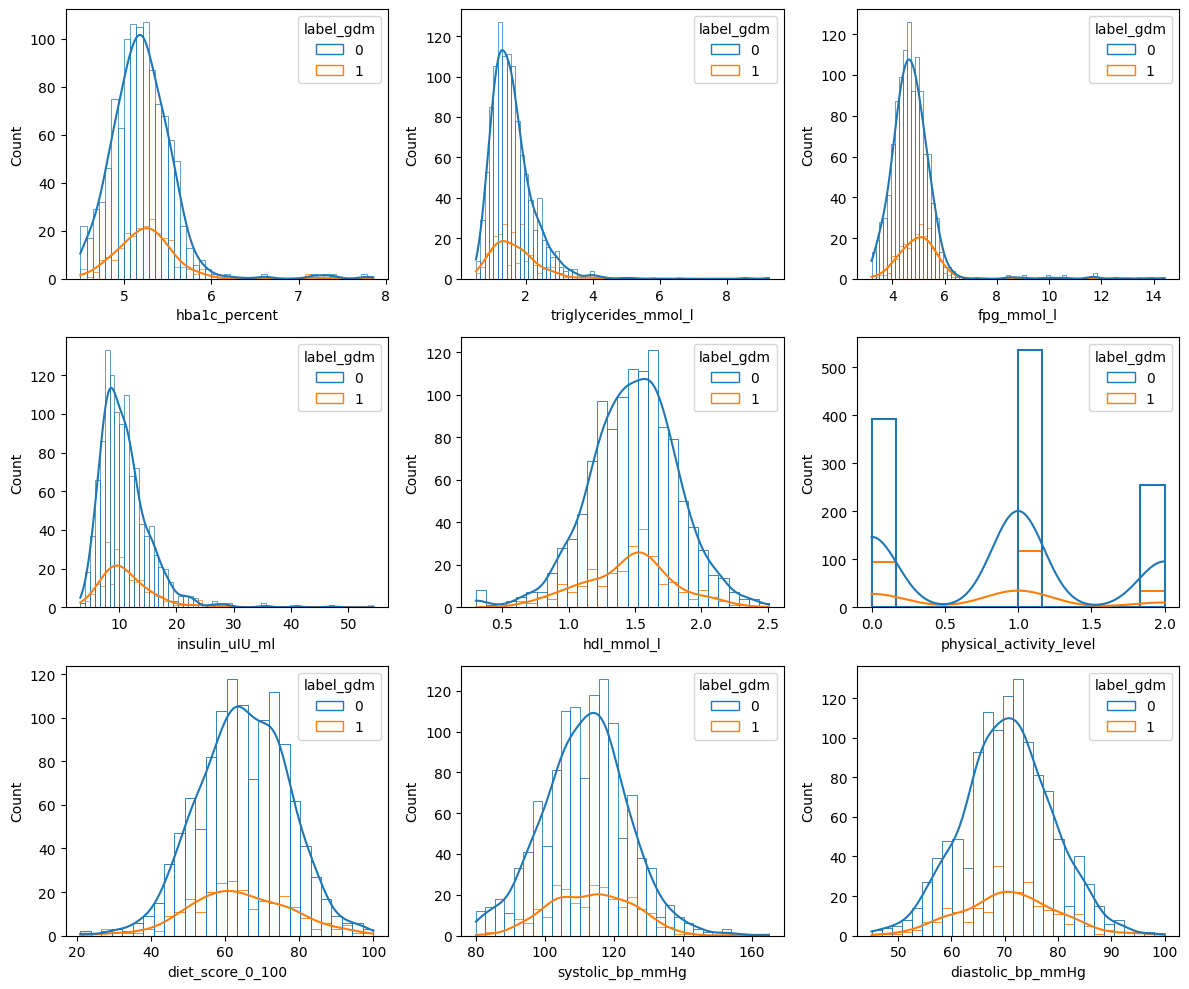

In [67]:
_, axis = plt.subplots(3,3, figsize=(12,10))

i=0
j=0

for index in range(1, 10):
    sns.histplot(ax=axis[i][j], data=df_data, x=columns_with_null[index-1], hue="label_gdm", fill=False, kde=True)

    if index%3 == 0:
        i+=1
        j=0
    else:
        j+=1
    
plt.tight_layout()

In [68]:
df_positivo = df_data[df_data["label_gdm"] == 1]
df_negativo = df_data[df_data["label_gdm"] == 0]

df_positivo = df_positivo.fillna(df_positivo.mean())
df_negativo = df_negativo.fillna(df_negativo.mean())

df_imputado = pd.concat([df_positivo, df_negativo], axis=0)

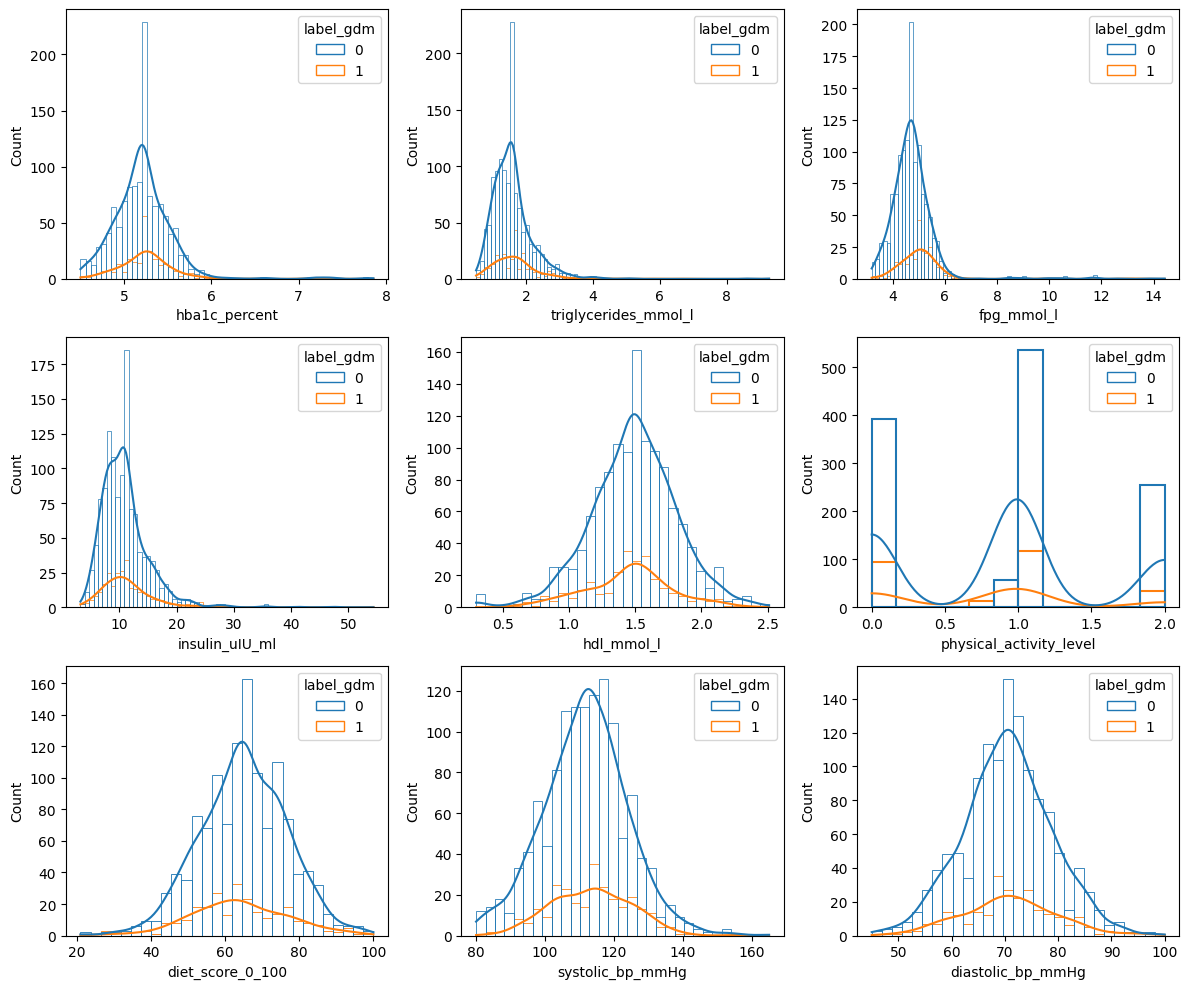

In [69]:
_, axis = plt.subplots(3,3, figsize=(12,10))

i=0
j=0

for index in range(1, 10):
    sns.histplot(ax=axis[i][j], data=df_imputado, x=columns_with_null[index-1], hue="label_gdm", fill=False, kde=True)

    if index%3 == 0:
        i+=1
        j=0
    else:
        j+=1
    
plt.tight_layout()